## 6-4 LSTM을 사용한 언어 모델
Time LSTM 계층을 구현해봤으니, 본래 주제인 __언어 모델__을 구현할 차례입니다. <br>
여기서 구현하는 __언어 모델__은 앞장에서 구현한 언어 모델과 거의 같습니다. <br>
[그림 6-26]에서 보듯, 앞 장에서는 Time RNN 계층이 차지하던 부분이 Time LSTM 계층으로 바뀌었는데, 이것이 유일한 차이입니다.

In [2]:
from common.time_layers import *
from common.base_model import BaseModel

import pickle

# https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/rnnlm.py
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

> Rnnlm 클래스에는 Softmax 계층 직전까지를 처리하는 predict() 메서드가 추가되었습니다. <br>
__이 메서드는 7장에서 수행하는 문장 생성에 사용됩니다.__ 그리고, 매개변수 읽기/쓰기를 처리하는 load_params()와 save_params() 메서드도 추가되었습니다. 나머지는 앞 장의 SimpleRnnlm 클래스와 같다.

___이제 이 신경망을 사용해 PTB 데이터셋을 학습시켜보겠습니다.___ <br>
이번에는 PTB 데이터셋의 훈련데이터 전부를 사용해 학습합니다. (앞 장에서는 PTB 데이터셋의 일부만 이용했습니다). <br>
학습을 위한 코드는 다음과 같습니다. (ch06/train_rnnlm.py)

| 에폭 1 |  반복 1 / 414 | 시간 0[s] | 퍼플렉서티 10000.07
| 에폭 1 |  반복 51 / 414 | 시간 29[s] | 퍼플렉서티 1699.51
| 에폭 1 |  반복 101 / 414 | 시간 57[s] | 퍼플렉서티 817.76
| 에폭 1 |  반복 151 / 414 | 시간 86[s] | 퍼플렉서티 588.21
| 에폭 1 |  반복 201 / 414 | 시간 116[s] | 퍼플렉서티 494.47
| 에폭 1 |  반복 251 / 414 | 시간 145[s] | 퍼플렉서티 461.44
| 에폭 1 |  반복 301 / 414 | 시간 177[s] | 퍼플렉서티 387.40
| 에폭 1 |  반복 351 / 414 | 시간 207[s] | 퍼플렉서티 362.72
| 에폭 1 |  반복 401 / 414 | 시간 237[s] | 퍼플렉서티 322.76


C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-

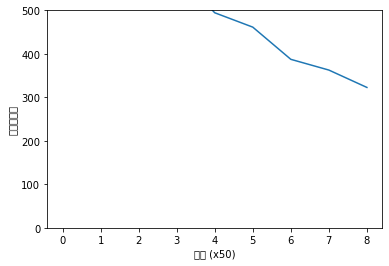

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  296.54361078424716


In [3]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 64
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 1
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=50)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

앞장과의 차이는 __기울기 클리핑__의 진행 여부, 빠른 진행을 위해 에폭수는 줄였음 <br>
에폭 수 늘려도, 퍼플렉서티가 만족스러운 결과는 아니므로, 아래에서 성능을 한층 더 개선할 계획이다.

##### 6.5 RNNLM 추가 개선
이번 절에서는 현재의 RNNLM의 개선 포인트 3가지를 설명합니다. 그리고 그 개선들을 구현하고, 마지막에는 실제로 얼마나 좋아졌는지를 평가해보겠습니다. 

##### 6.5.1 LSTM 계층 다층화
RNNLM으로 정확한 모델을 만들고자 한다면 많은 경우 LSTM을 깊게 쌓아(계층을 여러겹 쌓아)효과를 볼 수 있다.
![](img/fig-6-29.png)

지금까지 우리는 LSTM 계층을 1층만 사용했지만 이를 2층, 3층 식으로 여러겹 쌓으면 언어 모델의 정확도가 향상되리라 기대할 수 있습니다. <br>예컨대 LSTM을 2층으로 쌓아 RNNLM을 만든다고 하면 위 [그림6-29]처럼 됩니다. <br>

[그림6-29]는 LSTM계층을 두 개 쌓은 모습입니다. 이때 첫 번째 LSTM 계층의 은닉 상태가 두번째 LSTM 계층에 입력됩니다. 이와 같은 요령으로 LSTM 계층을 몇층이라도 쌓을 수 있으며, 그 결과 더 복잡한 패턴을 학습할 수 있게 됩니다. 피드포워드 신경망에서 계층을 쌓는 이야기와 같다.  <br>

PTB 데이터 셋의 언어모델은 보통 LSTM의 층 수를 2~4 정도로 할 때 좋은 결과를 얻는다.

##### 6.5.2 Dropout에 의한 과적합 억제
LSTM 계층을 다층화 하면 시계열 데이터의 복잡한 의존관계를 학습할 수 있을 것이라 기대할 수 있습니다. 다르게 표현하자면, 층을 깊게 쌓음으로써 표현력이 풍부한 모델을 만들 수 있다. 그러나, 이러한 모델은 종종__과적합__을 일으킵니다.  <br>심지어는 RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합이 발생한다.  <br>
따라서 RNN의 과적합 대책은 중요하고, 현재도 활발하게 연구되는 주제이다. 

![](img/fig-6-30.png)

드롭아웃은 무작위로 뉴런을 선택하여 선택한 뉴런을 무시한다. 무시한다는 말은 그 앞 계층으로부터의 신호 전달을 막는다는 뜻이다.<br>
이 __무작위한 무시__가 제약이 되어 신경망의 일반화 성능은 개선한 것이다. 

![](img/fig-6-31.png)

이 그림은 드롭아웃 계층에 활성화 함수 뒤에 삽입하는 방법으로 과적합 억제에 기여하는 모습이다. <br>
RNN을 사용한 모델에서 드롭아웃 계층을 LSTM 계층의 시계열 방향으로 삽입하는 것인데, __이는 좋은 방법이 아니다.__

![](img/fig-6-32.png)

RNN에서 시계열 방향으로 드롭아웃을 학습 시 넣어버리면 시간이 흐름에 따라 정보가 사라질 수 있다 . <br>
즉, 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다. <br>

드롭아웃 계층을 깊이 방향(상하 방향)으로 삽입하는 방안을 생각해보자.

![](img/fig-6-33.png)

위처럼 구성하면 시간 방향으로 아무리 진행해도 정보를 잃지 않는다. 드롭 아웃이 시간축과는 독립적으로 깊이 방향에만 영향을 주는 것이다. <br>

일반적인 드롭아웃은 시간방향에는 적합하지 않다. RNN의 시간 방향 정규화를 목표로 하는 방법이 다양하게 제안되다가 __변형 드롭아웃__이 제안되어 시간 방향으로 적용하는 데 성공했다.

![](img/fig-6-34.png)

계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 __고정__된다. 그 결과 정보를 잃게되는 방법도 __고정__ 되므로, 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있습니다. 

##### 6.5.3 가중치 공유
언어 모델을 개선하는 아주 간단한 트릭 중 __가중치 공유__가 있습니다. weight tyig 을 직역하면 '가중치를 연결한다'이지만, 실질적으로는 [그림 6-35]에서 보듯 가중치를 공유하는 효과를 줍니다.

![](img/fig-6-35.png)

__가중치 공유는 Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는 기법이다.__ <br>
두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술이다.

두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술입니다. <br>

그럼, 가중치 공유를 구현 관점에서 생각해봅시다. <br>
> - 어휘 수를 $V$로, LSTM의 은닉 상태의 차원 수를 $H$로 가정
> - 그러면 Embedding 계층의 가중치는 형상이 $V$x$H$이며
> - Affine 계층의 가중치 형상은 $H$x$V$가 됩니다.
> - 이때 가중치 공유를 적용하려면 Embedding 계층의 가중치를 전치하여 Affine 계층의 가중치로 설정하기만 하면 됩니다. 그리고 이 아주 간단한 트릭 하나로 훌륭한 결과를 얻을 수 있다.

##### 6.5.4 개선된 RNNLM 구현
![](img/fig-6-36.png)

위 그림[6-36]에서 보듯, 여기에서의 개선점은 다음 세가지이다. 
- LSTM 계층의 다층화(여기에서는 2층)
- 드롭아웃 사용(깊이 방향으로만 적용)
- 가중치 공유(Embedding 계층과 Affine 계층에서 가중치 공유)

In [4]:
#https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/better_rnnlm.py

from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()